# Trained and tested ResNet18

In [1]:
## Libraries 

In [38]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
import pickle

In [39]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Reshape, Layer, Activation, GlobalAveragePooling2D, Add, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D 
from keras.utils import np_utils
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization

In [40]:
import seaborn as sns
# Default seaborn look and feel
sns.set() 
plt.style.use('ggplot')

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
local_full_path="/Users/lmoh/code/Dekkerz/mocap/notebooks"

categ_colname='Class_label'
ts_field='timestamp_WD' 

In [41]:
pwd

'/Users/lmoh/code/Dekkerz/mocap/notebooks'

In [42]:
##ok, it's ime to make X, y from a whole dataset...

drop_dups=True
drop_dups_str="_no_dups" if drop_dups else ""

sampling=50  #sampling rate
win_len=20   #wind size in secs

#overlap will add 2nd pass moving init windsow position...
#seems to add only 3% to prec/recall...

overlap=True 
overlap_len=(win_len-10)*sampling  #n secs overlap, dont make it neg !
                                  #here on overap pass we start nead the end of 1st frame
    
overlap_str="_with_overlap" if overlap else ""

feature_set="accel" # "accel" or "accel+gyro"

ignore_dudes = [ "Participant10" ]

adjusted=1
adjusted_str="_sensor_adjusted" if adjusted != 1 else ""
    
sensors=[ 'Linear_acceleration_sensor_x_WD', 
          'Linear_acceleration_sensor_y_WD', 
          'Linear_acceleration_sensor_z_WD'] 

sensors_weights={ "Linear_acceleration_sensor_x_WD": 1.0 * adjusted, 
                  "Linear_acceleration_sensor_y_WD": 1.0 * adjusted, 
                  "Linear_acceleration_sensor_z_WD": 1.0 }
    
# our rgb-likes & sensor weights
if feature_set == "accel+gyro" : 
    
  sensors.extend(['Gyroscope_x_PD', 
                  'Gyroscope_y_PD', 
                  'Gyroscope_z_PD'])
  sensors_weights.update({ "Gyroscope_x_PD": 1.0, 
                           "Gyroscope_y_PD": 1.0, 
                           "Gyroscope_z_PD": 1.0 * adjusted })
    
tot_frame_len=sampling*win_len
n_sensors=len(sensors)

#prefer to hardcode expected act_types here...

act_types=[ 'DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand' ]
n_act_types=len(act_types)
  
remap_acts=False
if remap_acts:
  act_types_mapping={ 'drink' : [ 'DrinkSD', 'DrinkST' ],  
                      'smoke' : [ 'SmokeSD', 'SmokeST' ],  
                      'static': [ 'Sit',     'Stand'   ],
                      'eat'   : [ 'Eat'  ] 
                    }
  
id_str=str(len(sensors)) + "apple_sensors_" + str(win_len) + "_win" + overlap_str+drop_dups_str+adjusted_str

In [43]:
save_2picke = False 
load_from_pickle=True

x_obj_fname=x_dir + "/" + "x_" + id_str + "_secs.dump"

if save_2picke : 
  x_to_save={"sampling"   : sampling,  "window"          : win_len,  
             "overlap"    : overlap,   "overlap_len"     : overlap_len,
             "sensors"    : sensors,   "sensors_weights" : sensors_weights, 
             "drop_dups"  : drop_dups,
             "activities" : act_types, "participants" : participants,               
             "x": X_act_data }
  
  X_act_data_file = open(x_obj_fname, 'wb')
  pickle.dump(x_to_save, X_act_data_file)
  X_act_data_file.close()
  print("saved  x to {}".format(x_obj_fname))

if load_from_pickle :
  if os.path.exists(x_obj_fname) :
    try:
       X_act_data_file = open(x_obj_fname, 'rb')
       x_to_save = pickle.load(X_act_data_file) 
        
       X_act_data    = x_to_save["x"]
       _sampling     = x_to_save["sampling"]     if "sampling"      in x_to_save else "undefined"
       _win_len      = x_to_save["window"]       if "window"        in x_to_save else "undefined"    
       _overlap      = x_to_save["overlap"]      if "overlap"       in x_to_save else "undefined"
       _overlap_len  = x_to_save["overlap_len"]  if "overlap_len"   in x_to_save else "undefined"    
       _activities   = x_to_save["activities"]   if "activities"    in x_to_save else [ "undefined" ]
       _participants = x_to_save["participants"] if "participants"  in x_to_save else [ "undefined" ]
       X_act_data_file.close()
    
       print("loaded x of len {} ok from {}".format(len(X_act_data), x_obj_fname))
       print("sampling: {}, win_len: {}, overlap {}, overlap_len {}".format(_sampling, _win_len, _overlap, _overlap_len))
       print("participants: {}".format(", ".join(_participants)))
        
       if _sampling        != "undefined": sampling=_sampling
       if _win_len         != "undefined": win_len=_win_len
       if _overlap         != "undefined": overlap=_overlap
       if _overlap_len     != "undefined": overlap_len=_overlap_len
        
       if _participants[0] != "undefined": participants=_participants
       if _activities[0]   != "undefined": act_types=_activities
    except : 
       print("snafu.. on loading from {}".format(x_obj_fname))
    
  else:
     print("no such file: {}".format(x_obj_fname))

loaded x of len 10 ok from UT_Smoking_Data_x/x_3apple_sensors_20_win_with_overlap_no_dups_secs.dump
sampling: 50, win_len: 20, overlap True, overlap_len 500
participants: Participant11_Data.pickle, Participant1_Data.pickle, Participant2_Data.pickle, Participant3_Data.pickle, Participant4_Data.pickle, Participant5_Data.pickle, Participant6_Data.pickle, Participant7_Data.pickle, Participant8_Data.pickle, Participant9_Data.pickle


In [44]:
print("n parts: {}, n categs: {}".format(len(X_act_data), len(X_act_data[0])))

n parts: 10, n categs: 7


In [45]:
mtype="Conv1D" #cnn, rnn, conv_rnn

do_padding=False
    
X=[]; y=[]                        

for n_patient in range(1, len(X_act_data)):  
  x_patient_data=X_act_data[n_patient-1]
  for act_type in x_patient_data:
    activity_data=x_patient_data[act_type]
    for window_idx in range(0, len(activity_data)):
      X.append(np.asarray(activity_data[window_idx]))  
      if remap_acts :
        for  k, v in act_types_mapping.items():
          if act_type in v :  act_type=k; break 
      y.append(act_type)      

if remap_acts: 
    act_types = act_types_mapping.keys()
    print("remapped activities to {}".format(", ".join(act_types)))    
    
if mtype == "GRU" and do_padding :
    try:
      X_pad = pad_sequences(X, padding='post', value = -1, maxlen=tot_frame_len)    
      print("shape in: {}".format(str(X_pad.shape))) 
      X=X_pad
    except :
      print("bad day... (or nite...)")

In [46]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn import metrics

from tensorflow import keras
import keras.backend as K

from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization, Input

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.layers import Dense, Flatten, Masking, Dropout
from tensorflow.keras.layers import GRU, LSTM, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.metrics import Recall, Precision

from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D

In [47]:
encoder = LabelBinarizer()
y_ohe= encoder.fit_transform(y)

print("mtype {}..".format(mtype))
X_np=np.asarray(X)
if mtype == "Conv2D" or mtype == "Conv1D" : 
  print("reshaping..")
  X_np=X_np.reshape(len(X_np), win_len, sampling, n_sensors)  
    
print("shape for mode {}: X: {}, y: {}".format(mtype, str(X_np.shape), str(y_ohe.shape)))

mtype Conv1D..
reshaping..
shape for mode Conv1D: X: (9667, 20, 50, 3), y: (9667, 7)


In [48]:
X_np.shape

(9667, 20, 50, 3)

In [51]:
do_shuffle=True
X_train, X_test, y_train, y_test = train_test_split(X_np, y_ohe, test_size = 0.3, random_state = 1, shuffle=do_shuffle)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.5, 
                                                    #random_state = 1, shuffle=do_shuffle)


## Model

In [52]:
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding="same", **kwargs):
        super(CustomConv2D, self).__init__()
        self.conv = Conv2D(filters = n_filters,
                           kernel_size = kernel_size,
                           activation='relu', 
                           strides=n_strides, 
                           padding=padding)
            
            #self.batch_norm = BatchNormalization()
        
    def call(self, x):
        x = self.conv(x)
       #x = self.batch_norm(x)
            
        return x

In [53]:
class ResidualBlock(Layer):
        def __init__(self, n_channels, n_strides=1):
            super(ResidualBlock, self).__init__() 
            
            self.dotted = (n_strides != 1)
            
            self.custom_conv_1= CustomConv2D(n_channels, 3, n_strides, padding="same")
            self.batch_norm1 = BatchNormalization(axis=3)
            self.custom_conv_2= CustomConv2D(n_channels, 3, 1, padding="same")
            self.batch_norm2 = BatchNormalization(axis=3)
            
            self.activation = Activation('relu')
            if self.dotted:
                self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
            
        
        def call(self, input):
            x = self.custom_conv_1(input)
            x = self.batch_norm1(x)
            x = self.custom_conv_2(x)
            x = self.batch_norm2(x)
            
            if self.dotted:
                x_add = self.custom_conv_3(input)
                x_add = Add()([x, x_add])
            else: 
                    x_add = Add()([x, input])
                    
            return self.activation(x_add)
    
            

In [54]:
#Coding ResNet from scratch, as seen in the paper 
class ResNet18(Model):
    def __init__(self, **kwargs):
        super(ResNet18, self).__init__()
        
        #conv layer
        self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
        self.batch_norm = BatchNormalization(axis=3)
        self.max_pool = MaxPooling2D((4, 2))
        
        #Res layers
        self.conv_2_1 = ResidualBlock(64, 2)
        self.conv_2_2 = ResidualBlock(64)
        
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        
        #Global average pooling / Flatten / Dense / Output layer 
        
        self.global_pool = GlobalAveragePooling2D()
        self.flatten = Flatten()
        self.dense_32 = Dense(32,activation='relu')
        self.dense_7 = Dense(7, activation='softmax')
        
    def call(self, x): 
        #conv layer
        x = self.conv_1(x)
        x = self.batch_norm(x)
        x = self.max_pool(x)
        
        #res layers
        x = self.conv_2_1(x)
        x = self.conv_2_2(x)
        
        x = self.conv_3_1(x)
        x = self.conv_3_2(x)
        
        x = self.conv_4_1(x)
        x = self.conv_4_2(x)
        
        x = self.conv_5_1(x)
        x = self.conv_5_2(x)
        
        #output shenanigans 
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.dense_32(x)
        
        
        return self.dense_7(x)

In [55]:
model = ResNet18()

In [56]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
#fittingggg
model.fit(X_np, y_ohe, epochs=20)

Epoch 1/20
303/303 [==============================] - 184s 608ms/step - loss: 1.1961 - accuracy: 0.5334
Epoch 2/20
303/303 [==============================] - 189s 624ms/step - loss: 1.0504 - accuracy: 0.5951
Epoch 3/20
303/303 [==============================] - 178s 589ms/step - loss: 0.9483 - accuracy: 0.6431
Epoch 4/20
303/303 [==============================] - 183s 604ms/step - loss: 0.8395 - accuracy: 0.6878
Epoch 5/20
303/303 [==============================] - 188s 619ms/step - loss: 0.7479 - accuracy: 0.7204
Epoch 6/20
303/303 [==============================] - 165s 543ms/step - loss: 0.7812 - accuracy: 0.7114
Epoch 7/20
303/303 [==============================] - 159s 526ms/step - loss: 0.6671 - accuracy: 0.7580
Epoch 8/20
303/303 [==============================] - 147s 487ms/step - loss: 0.6447 - accuracy: 0.7636
Epoch 9/20
303/303 [==============================] - 151s 497ms/step - loss: 0.7170 - accuracy: 0.7489
Epoch 10/20
303/303 [==============================] - 158s 520m

In [ ]:
#evaluationnnn

In [ ]:
res = model.evaluate(X_test, y_test)

print(model.metrics_names)
loss=res[0]
recall=res[1]
precision=res[2]
prc=res[3]
print("{}, {}, {}, {}".format(res[0], res[1], res[2], res[3]))

In [61]:
#the jsonnnnssss
#loading new data
os.chdir('/Users/lmoh/code/Dekkerz/mocap')
!ls -ltr setup.py

-rw-r--r--  1 lmoh  staff  375 Dec  5 10:41 setup.py


In [62]:
pwd

'/Users/lmoh/code/Dekkerz/mocap'

In [63]:
!pip install psutil
!pip install colorama
# the install -e auto re-loads so that and local changes to the mocap .py files are used.
!pip install -e .

Obtaining file:///Users/lmoh/code/Dekkerz/mocap
  Preparing metadata (setup.py) ... done


  Attempting uninstall: mocap
    Found existing installation: mocap 0.0.2
    Uninstalling mocap-0.0.2:
      Successfully uninstalled mocap-0.0.2
  Running setup.py develop for mocap
^C
ERROR: Operation cancelled by user


In [65]:
!direnv allow

In [66]:
def load_json(file) -> pd.DataFrame:
        print(file)
        df=pd.read_json(path_or_buf=file,orient='records')
        return(df)

In [67]:
load_json('2022-12-06T15_45_20Z.json')
load_json('2022-12-06T15_45_37Z.json')
load_json('2022-12-06T15_48_57Z.json')
load_json('2022-12-06T15_49_09Z.json')
load_json('2022-12-06T15_50_37Z.json')
load_json('2022-12-06T15_50_48Z.json')
load_json('2022-12-06T15_50_59Z.json')
load_json('2022-12-06T15_51_08Z.json')
load_json('2022-12-06T15_51_16Z.json')
load_json('2022-12-06T15_51_26Z.json')
load_json('2022-12-06T15_54_04Z.json')
load_json('2022-12-06T15_54_13Z.json')
load_json('2022-12-06T15_54_30Z.json')
load_json('2022-12-06T15_54_47Z.json')
load_json('2022-12-06T15_54_57Z.json')
load_json('2022-12-06T15_55_16Z.json')
load_json('2022-12-06T15_55_26Z.json')
load_json('2022-12-06T15_55_38Z.json')

2022-12-06T15_45_20Z.json
2022-12-06T15_45_37Z.json
2022-12-06T15_48_57Z.json
2022-12-06T15_49_09Z.json
2022-12-06T15_50_37Z.json
2022-12-06T15_50_48Z.json
2022-12-06T15_50_59Z.json
2022-12-06T15_51_08Z.json
2022-12-06T15_51_16Z.json
2022-12-06T15_51_26Z.json
2022-12-06T15_54_04Z.json
2022-12-06T15_54_13Z.json
2022-12-06T15_54_30Z.json
2022-12-06T15_54_47Z.json
2022-12-06T15_54_57Z.json
2022-12-06T15_55_16Z.json
2022-12-06T15_55_26Z.json
2022-12-06T15_55_38Z.json


,Engineered_Timestamp,Linear_acceleration_sensor_y_WD,Linear_acceleration_sensor_z_WD,Linear_acceleration_sensor_x_WD,Class_Encoded
0,1670342133670,0.920074,-0.313919,-0.134613,3
1,1670342133685,0.976685,-0.295914,-0.172699,3
2,1670342133705,0.889801,-0.301376,-0.123962,3
3,1670342133724,0.950134,-0.312164,-0.139206,3
4,1670342133745,0.965866,-0.284622,-0.142715,3
...,...,...,...,...,...
246,1670342138574,1.039871,-0.301727,-0.201279,3
247,1670342138594,1.024170,-0.301498,-0.208221,3
248,1670342138614,1.005524,-0.292862,-0.217148,3
249,1670342138634,1.002396,-0.297546,-0.230591,3


In [68]:
data_dir='/Users/lmoh/code/Dekkerz/mocap/'
endswith='.json'

files=[]
#loop through files in the data_dir
for file in os.listdir(data_dir):
    if file.endswith(endswith):
        filename=os.path.join(data_dir,file)
        print(filename)
        files.append(filename)

watch_data=pd.concat(map(load_json,files))

/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_50_37Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_54_47Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_55_26Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_51_08Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_54_04Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_55_38Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_51_16Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_50_48Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_45_20Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_54_57Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_45_37Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_54_30Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_49_09Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_55_16Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_50_59Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_48_57Z.json
/Users/lmoh/code/Dekkerz/mocap/2022-12-06T15_51_26Z.json
/Users/lmoh/code/Dekkerz/mocap/

In [69]:
import datetime
watch_data['Engineered_Timestamp']=watch_data['Engineered_Timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x/1000))

watch_data=watch_data.sort_values(by=['Engineered_Timestamp'],ignore_index=True)

In [71]:
df_smoke = watch_data[['Linear_acceleration_sensor_x_WD', 'Linear_acceleration_sensor_y_WD', 'Linear_acceleration_sensor_z_WD']][0:tot_frame_len]

In [72]:
df_stand = watch_data[['Linear_acceleration_sensor_x_WD', 'Linear_acceleration_sensor_y_WD', 'Linear_acceleration_sensor_z_WD']].tail(tot_frame_len)

In [94]:
#copy probs_to_cats function here
X_test = watch_data.drop(columns=['Engineered_Timestamp', 'Class_Encoded'])
y_test = watch_data['Class_Encoded']

In [100]:
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
X_test.shape

(4332, 3)

In [97]:
#model.evaluate(X_test, y_test)

ValueError: in user code:

    File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/engine/training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/06/bsdxkm7j1tnclcj0g97ll0cw0000gn/T/__autograph_generated_filemow13p3p.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).conv_1, (ag__.ld(x),), None, fscope)
    File "/var/folders/06/bsdxkm7j1tnclcj0g97ll0cw0000gn/T/__autograph_generated_fileft76t8gp.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(self).conv, (ag__.ld(x),), None, fscope)

    ValueError: Exception encountered when calling layer 'res_net18_2' (type ResNet18).
    
    in user code:
    
        File "/var/folders/06/bsdxkm7j1tnclcj0g97ll0cw0000gn/T/ipykernel_29286/2214777883.py", line 33, in call  *
            x = self.conv_1(x)
        File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/var/folders/06/bsdxkm7j1tnclcj0g97ll0cw0000gn/T/__autograph_generated_fileft76t8gp.py", line 10, in tf__call
            x = ag__.converted_call(ag__.ld(self).conv, (ag__.ld(x),), None, fscope)
    
        ValueError: Exception encountered when calling layer 'custom_conv2d_42' (type CustomConv2D).
        
        in user code:
        
            File "/var/folders/06/bsdxkm7j1tnclcj0g97ll0cw0000gn/T/ipykernel_29286/2743863249.py", line 13, in call  *
                x = self.conv(x)
            File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
                raise e.with_traceback(filtered_tb) from None
            File "/Users/lmoh/.pyenv/versions/3.10.6/envs/mocap/lib/python3.10/site-packages/keras/engine/input_spec.py", line 250, in assert_input_compatibility
                raise ValueError(
        
            ValueError: Input 0 of layer "conv2d_42" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 3)
        
        
        Call arguments received by layer 'custom_conv2d_42' (type CustomConv2D):
          • x=tf.Tensor(shape=(None, 3), dtype=float32)
    
    
    Call arguments received by layer 'res_net18_2' (type ResNet18):
      • x=tf.Tensor(shape=(None, 3), dtype=float32)


In [79]:
def probs_to_cats(yp, encoder):
   ypt=np.zeros((len(yp[0]),), dtype=int)
   maxpos=np.argmax(yp)
   ypt[maxpos]=1 
   return encoder.inverse_transform(np.expand_dims(ypt, axis=0))[0]

In [86]:
#y_test = watch_data['Class_Encoded']
#y_test = np.asarray(y_test)
#model.evaluate(X_test, y_test)

ValueError: Data cardinality is ambiguous:
  x sizes: 1
  y sizes: 4332
Make sure all arrays contain the same number of samples.

In [80]:
X_test=np.asarray(df_smoke)
X_test=X_test.reshape(1, win_len, sampling, n_sensors)  
 
y_pred=model.predict(X_test)
print(y_pred)
probs_to_cats(model.predict(X_test), encoder)



1/1 [==============================] - 0s 63ms/step
[[1.8412637e-03 1.4644862e-03 9.8242652e-01 1.3678915e-04 1.0065204e-04
  1.4030264e-02 1.9593235e-18]]
1/1 [==============================] - 0s 59ms/step


'Eat'

In [81]:
X_test=np.asarray(df_stand)
X_test=X_test.reshape(1, win_len, sampling, n_sensors)  
 
y_pred=model.predict(X_test)
print(y_pred)
probs_to_cats(model.predict(X_test), encoder)


1/1 [==============================] - 0s 64ms/step
[[1.0252639e-01 4.7119641e-01 4.1596523e-01 6.8318582e-04 2.9880651e-03
  6.6405567e-03 2.1209033e-07]]
1/1 [==============================] - 0s 62ms/step


'DrinkST'

In [ ]:
#Confusion matrix, ignore big time

91/91 [==============================] - 2s 16ms/step


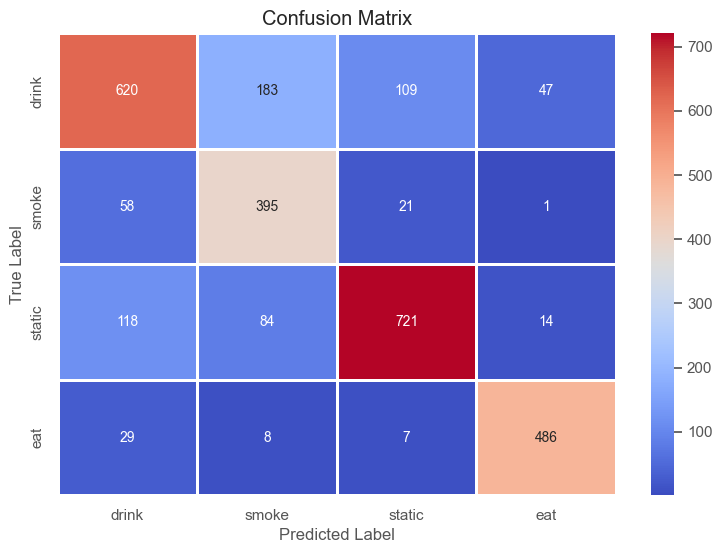

In [27]:
from sklearn import metrics
def confusion_matrix(y, y_pred, labels):    
    matrix = metrics.confusion_matrix(y, y_pred)
    plt.figure(figsize=(9, 6))
    ax= sns.heatmap(matrix, cmap='coolwarm', linecolor='white', 
                    linewidths=1, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    #bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
y_test_idx=[]
for idx in range (0, len(y_test)):
  elem=y_test[idx]
  for ncat in range(0, len(elem)):
    if elem[ncat] == 1 :
        y_test_idx.append(ncat) 
        break

y_pred_ohe = model.predict(X_test)
y_pred_idx=np.argmax(y_pred_ohe,axis=1)
y_pred_idx_list=y_pred_idx.tolist()

act_labels = act_types_mapping.keys() if remap_acts else act_types

confusion_matrix(y_test_idx, y_pred_idx_list, act_labels)


     

In [28]:
def plot_history(history, optimizer_str, axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    pkey="precision"; vpkey="val_precision"
    for key in history.history.keys():
      if key.startswith("precision")       : pkey=key; 
      elif key.startswith("val_precision") : vpkey=key; 
        
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
               
    ax2.plot(history.history[pkey], label='train accuracy'  + exp_name)
    ax2.plot(history.history[vpkey], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy ' + optimizer_str)
    ax2.legend()
    return (ax1, ax2)


     

In [30]:
model.fit(X_np, y_ohe, epochs=20, validation_split=0.2)

Epoch 1/20
242/242 [==============================] - 140s 577ms/step - loss: 0.4373 - accuracy: 0.8484 - val_loss: 0.5110 - val_accuracy: 0.8113
Epoch 2/20
192/242 [======================>.......] - ETA: 29s - loss: 0.3381 - accuracy: 0.8848

KeyboardInterrupt: 